# Prerequisites

In [1]:
import os, sys

import numpy as np
import tqdm
import torch

/home/marco/miniconda3/envs/nlp2022-hw2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Important paths for the notebook:

In [2]:
app_root = '../../../../'
test_name = 'test2_wikidump_learn'
datasets_path = os.path.join(app_root, 'data')
model_dir_path = os.path.join(app_root, 'model', test_name)

datasets_paths = {}
for lang in os.listdir(datasets_path):
    dataset_lang_path = os.path.join(datasets_path, lang)
    if os.path.isdir(dataset_lang_path):
        datasets_paths[lang] = {}
        for d_type in os.listdir(dataset_lang_path):
            d_name = d_type.split('.')[0]
            datasets_paths[lang][d_name] = os.path.join(dataset_lang_path, d_type)

In [3]:
sys.path.append('../../../')

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [4]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
global_params = {
    'batch_size': 32,
    'PAD_TOKEN': '<pad>',
    'UNK_TOKEN': '<unk>',
    'transformer_name': "xlm-roberta-base",
}

# Dataset

I will use BERT

In [6]:
from stud.modelsTests.dataset.SRLDataset_transformer import SRLDataset_transformer

In [7]:
dataset_train_en = SRLDataset_transformer(  datasets_paths['EN']['train'], 
                                            tokenizer = global_params['transformer_name'],
                                            baselines_file_path = os.path.join(app_root,'data/baselines.json'))
dataset_train_es = SRLDataset_transformer(  datasets_paths['ES']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)
dataset_train_wiki_es = SRLDataset_transformer(     datasets_paths['ES']['train_wiki_es'], 
                                                    tokenizer = dataset_train_en.tokenizer,
                                                    labels = dataset_train_en.labels)
dataset_train_fr = SRLDataset_transformer(  datasets_paths['FR']['train'], 
                                            tokenizer = dataset_train_en.tokenizer,
                                            labels = dataset_train_en.labels)

In [8]:
SRLDataset_transformer.save_dict(
    os.path.join(model_dir_path, 'labels.npy'), 
    dataset_train_en.labels)

In [9]:
dataset_dev_es = SRLDataset_transformer(datasets_paths['ES']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)

In [10]:
dataset_dev_fr = SRLDataset_transformer(datasets_paths['FR']['dev'], 
                                        tokenizer = dataset_train_en.tokenizer,
                                        labels = dataset_train_en.labels)

In [11]:
next(iter(dataset_train_en)).keys()

dict_keys(['dependency_heads', 'dependency_relations', 'lemmas', 'pos_tags', 'predicates', 'roles', 'words', 'predicate_position', 'predicate_label', 'predicate_word'])

In [12]:
global_params.update({ 
    'n_roles_labels': len(dataset_train_en.labels['id_to_roles']),
    'n_predicates_labels': len(dataset_train_en.labels['id_to_predicates'])
})

Saving global variables...

In [13]:
np.save(os.path.join(model_dir_path, 'global_params.npy'), global_params)

# DataLoader

In [14]:
from torch.utils.data import DataLoader

In [15]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
num_workers = 4

In [16]:
dataloader_train_es = DataLoader(
    dataset_train_es,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_en.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [17]:
dataloader_train_wiki_es = DataLoader(
    dataset_train_wiki_es,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_wiki_es.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [18]:
dataloader_train_fr = DataLoader(
    dataset_train_fr,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_train_fr.create_collate_fn(),
    num_workers=num_workers,
    shuffle=True,
)

In [19]:
dataloader_dev_es = DataLoader(
    dataset_dev_es,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_es.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [20]:
dataloader_dev_fr = DataLoader(
    dataset_dev_fr,
    batch_size=global_params['batch_size'],
    collate_fn=dataset_dev_fr.create_collate_fn(),
    num_workers=num_workers,
    shuffle=False,
)

In [21]:
for e in dataloader_dev_es:
    ex_in = e
    break

In [22]:
ex_in.keys()

dict_keys(['input_ids', 'attention_mask', 'roles_formatted', 'matrix_subwords', 'output_mask', 'predicates', 'predicate_position', 'predicate_position_formatted', 'pos_tags'])

In [23]:
print(ex_in['input_ids'][0], ex_in['input_ids'].shape)
print(ex_in['output_mask'][0], ex_in['output_mask'].shape)
print(ex_in['roles_formatted'][0], ex_in['roles_formatted'].shape)

tensor([     0,    540,  95213, 188870,    144,  12383,  46836,     41, 182684,
          1005,  23139,     10,     21,  26000,  11313,      8,    388,  94572,
             8,    576,  58693,      7,    146,  15653,      6,      4,    576,
         58693,      7,      8,  28759,    113,    576,  58693,      7, 173222,
             7,  39372,      8,    576, 202207,      8,  54347,  40579,      6,
             5,      2,      2, 188870,      2,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1, 

In [24]:
print(ex_in['predicates'][0], ex_in['predicates'].shape)
print(ex_in['predicate_position_formatted'][0], ex_in['predicate_position_formatted'].shape)

tensor([ -1,   0,   0, 297,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         -1,   0,   0,   0,   0,   0,   0,  -1,   0,   0,   0,  -1,   0,   0,
         -1,   0,   0,   0,   0,   0,  -1,   0,  -1,   0,   0,   0,   0,   0,
          0,   0,   0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,
         -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -1]) torch.Size([32, 135])
tensor(3) torch.Size([32])


In [25]:
torch.set_printoptions(edgeitems=80)
print(ex_in['matrix_subwords'].shape,'\n' , ex_in['matrix_subwords'][0][0:6,:10]) # word_ids[0:6] = [None, 0, 1, 2, 2, 3]
torch.set_printoptions(edgeitems=3)

torch.Size([32, 135, 135]) 
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])


# Printing model

In [26]:
from torchinfo import summary

def print_summary(model):
    print(model)
    print('----------------------')
    p = sum(p.numel() for p in model.parameters())
    tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ntp = p - tp
    print('parameters:', f'{p:,}')
    print('trainable parameters:', f'{tp:,}')
    print('non-trainable parameters:', f'{ntp:,}')

import matplotlib.pyplot as plt

def display_history(dict_history):
    plt.figure(figsize=(8,8))
    for name, hist in dict_history.items():
        plt.plot([i for i in range(len(hist))], hist, label=name)
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title('Model learning')
    plt.legend()
    plt.show()

# Training the untrained model (Spanish)

In [27]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [28]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = False, # !
    loss_fn = loss_function,
    fine_tune_transformer = True, # !
    saves_path_folder='test2_roberta',
    model_save_file_path = os.path.join(app_root, 'model','test2_roberta','aic_transformer_roberta_weights.pth')
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [30]:
history = {}

In [31]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_wiki_es, dataloader_dev_es,
    epochs=60, device=device,
    save_best=True, 
    min_score=0.68,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_roberta_weights_es.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.253258
# Validation loss => 0.285122 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   1 => avg_loss: 0.217582
# Validation loss => 0.284766 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   2 => avg_loss: 0.216743
# Validation loss => 0.286726 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   3 => avg_loss: 0.216325
# Validation loss => 0.286696 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   4 => avg_loss: 0.215790
# Validation loss => 0.282675 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   5 => avg_loss: 0.215609
# Validation loss => 0.286286 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   6 => avg_loss: 0.215480
# Validation loss => 0.285976 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   7 => avg_loss: 0.209330
# Validation loss => 0.261082 | f1-score: arg_iden = 0.000000 arg_class = 0.000000 #
Epoch   8 => avg_loss: 0.192449
# Validation loss => 0.238930 | 

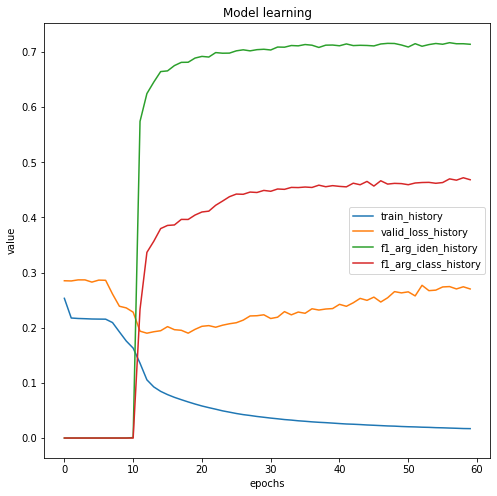

In [32]:
display_history(history)

# Finetuning the trained english model (for Spanish)

In [34]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [35]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = True, # !
    loss_fn = loss_function,
    fine_tune_transformer = True, # !
    saves_path_folder='test2_roberta', # !
    model_save_file_path = os.path.join(app_root, 'model','test2_roberta','aic_transformer_roberta_weights.pth')
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

In [36]:
freeze_some = False
if freeze_some:
    unfreeze_from_layer_num = 8
    unfreeze_to_layer_num = 99
    unfreeze_transformer_layers = True
    unfreeze_word_embeddings = True
    unfreeze_pooler = True
    unfreeze_classifier = True

    for name, param in final_model.model.named_parameters():

        if name.startswith('transformer_model.encoder.layer'):
            layer_num = int(name.split('.')[3])
            if layer_num >= unfreeze_from_layer_num and layer_num <= unfreeze_to_layer_num:
                param.requires_grad = unfreeze_transformer_layers
            else:
                param.requires_grad = False

        elif name.startswith('transformer_model.embeddings'):
            param.requires_grad = unfreeze_word_embeddings

        elif name.startswith('transformer_model.pooler'):
            param.requires_grad = unfreeze_pooler

        elif name.startswith('classifier'):
            param.requires_grad = unfreeze_classifier
        
        print(param.requires_grad, name)

        

In [37]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [38]:
history = {}

In [39]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_wiki_es, dataloader_dev_es,
    epochs=20, device=device,
    save_best=True, 
    min_score=0.68,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_roberta_weights_es.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.058064
# Validation loss => 0.147564 | f1-score: arg_iden = 0.731807 arg_class = 0.505637 #
Epoch   1 => avg_loss: 0.042944
# Validation loss => 0.154801 | f1-score: arg_iden = 0.727007 arg_class = 0.496065 #
Epoch   2 => avg_loss: 0.038678
# Validation loss => 0.164336 | f1-score: arg_iden = 0.725222 arg_class = 0.491228 #
Epoch   3 => avg_loss: 0.035768
# Validation loss => 0.168437 | f1-score: arg_iden = 0.725074 arg_class = 0.494867 #
Epoch   4 => avg_loss: 0.033416
# Validation loss => 0.177099 | f1-score: arg_iden = 0.724671 arg_class = 0.487235 #
Epoch   5 => avg_loss: 0.031506
# Validation loss => 0.180755 | f1-score: arg_iden = 0.726757 arg_class = 0.506981 #
Epoch   6 => avg_loss: 0.030297
# Validation loss => 0.182975 | f1-score: arg_iden = 0.730245 arg_class = 0.502725 #
Epoch   7 => avg_loss: 0.029057
# Validation loss => 0.184667 | f1-score: arg_iden = 0.726816 arg_class = 0.497319 #
Epoch   8 => avg_loss: 0.027708
# Validation loss => 0.193469 | 

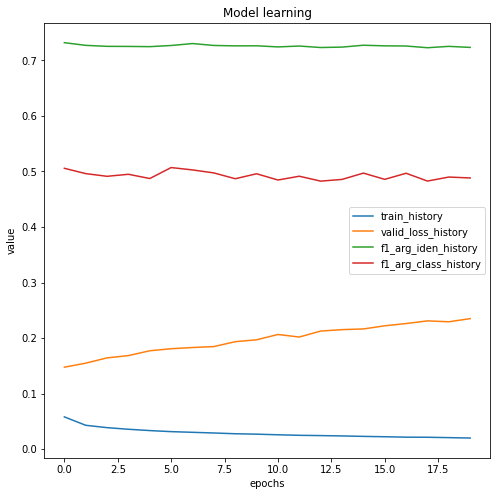

In [40]:
display_history(history)

# Finetuning the trained english model (for French)

In [45]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index = dataset_train_en.labels['roles_pad_id']) # !

In [46]:
from stud.modelsTests.model_arg_iden_class_part.Model_aic_transformer_simple import ArgIdenClassModel
import torch.optim as optim

final_model = ArgIdenClassModel(
    language = 'EN',
    device = device,
    model_load_weights = True, # !
    loss_fn = loss_function,
    fine_tune_transformer = True, # !
    saves_path_folder='test2_roberta', # !
    model_save_file_path = os.path.join(app_root, 'model','test2_roberta','aic_transformer_roberta_weights.pth')
)

optimizer = optim.SGD(final_model.model.parameters(), lr=0.0016, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0016)

In [47]:
freeze_some = False
if freeze_some:
    unfreeze_from_layer_num = 8
    unfreeze_to_layer_num = 99
    unfreeze_transformer_layers = True
    unfreeze_word_embeddings = True
    unfreeze_pooler = True
    unfreeze_classifier = True

    for name, param in final_model.model.named_parameters():

        if name.startswith('transformer_model.encoder.layer'):
            layer_num = int(name.split('.')[3])
            if layer_num >= unfreeze_from_layer_num and layer_num <= unfreeze_to_layer_num:
                param.requires_grad = unfreeze_transformer_layers
            else:
                param.requires_grad = False

        elif name.startswith('transformer_model.embeddings'):
            param.requires_grad = unfreeze_word_embeddings

        elif name.startswith('transformer_model.pooler'):
            param.requires_grad = unfreeze_pooler

        elif name.startswith('classifier'):
            param.requires_grad = unfreeze_classifier
        
        print(param.requires_grad, name)

        

In [48]:
print_summary(final_model.model)

Net_aic_transformer_simple(
  (transformer_model): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [49]:
history = {}

In [50]:
from stud.modelsTests.utils.Trainer_aic_transformer_simple import Trainer_aic_transformer_simple

trainer = Trainer_aic_transformer_simple()

history = trainer.train(
    final_model, optimizer, dataloader_train_fr, dataloader_dev_fr,
    epochs=30, device=device,
    save_best=True, 
    min_score=0.68,
    save_path_name=os.path.join(model_dir_path, 'aic_transformer_roberta_weights_fr.pth'),
    saved_history=history
)

Epoch   0 => avg_loss: 0.111896
# Validation loss => 0.083902 | f1-score: arg_iden = 0.846917 arg_class = 0.661454 #
Epoch   1 => avg_loss: 0.085273
# Validation loss => 0.077735 | f1-score: arg_iden = 0.850275 arg_class = 0.670606 #
Epoch   2 => avg_loss: 0.079202
# Validation loss => 0.073770 | f1-score: arg_iden = 0.850312 arg_class = 0.679064 #
Epoch   3 => avg_loss: 0.074988
# Validation loss => 0.075736 | f1-score: arg_iden = 0.849809 arg_class = 0.677574 #
Epoch   4 => avg_loss: 0.067579
# Validation loss => 0.074659 | f1-score: arg_iden = 0.852352 arg_class = 0.679949 #
Epoch   5 => avg_loss: 0.065558
# Validation loss => 0.073557 | f1-score: arg_iden = 0.851529 arg_class = 0.686717 #
----- Best value obtained, saving model -----
Epoch   6 => avg_loss: 0.061874
# Validation loss => 0.073241 | f1-score: arg_iden = 0.853839 arg_class = 0.685641 #
Epoch   7 => avg_loss: 0.058417
# Validation loss => 0.072308 | f1-score: arg_iden = 0.854183 arg_class = 0.698406 #
----- Best value o

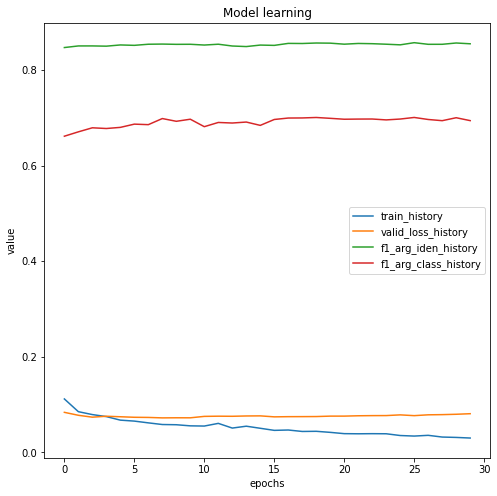

In [51]:
display_history(history)